In [1]:
import torch.nn as nn
import os
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import logging
import pandas as pd
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


/Users/maximilianruess/Documents/GitHub/DeepLearning_101/dl_101/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [4]:
# Set deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [9]:
# Set Seeds 
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [6]:
weights = torchvision.models.AlexNet_Weights.DEFAULT

alexnet = torchvision.models.alexnet(weights = weights).to(device)

automatic_transforms = weights.transforms()

In [7]:
automatic_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 10
RANDOM_SEED = 42

set_seed(RANDOM_SEED)

In [4]:
def build_dataloaders(data_path,  train_transforms, test_transforms, num_workers, batch_size): 
    
    train_dataset = datasets.CIFAR10(root = data_path, 
                                   transform= train_transforms, 
                                   download = True, 
                                   train = True) 

    test_dataset = datasets.CIFAR10(root= data_path, 
                                  transform=test_transforms, 
                                  train = False, 
                                  download = True, 
                                  )
    # Load the test dataset without any transformations for visualization purposes
    test_dataset_2 = datasets.CIFAR10(root= data_path,
                                    train = False, 
                                    download = True, 
                                    )
    
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers = num_workers,
                                  drop_last = True,
                                  persistent_workers=True)
    
    test_dataloader = DataLoader(test_dataset, 
                                 batch_size = batch_size, 
                                 shuffle = False, 
                                 num_workers=num_workers, 
                                 drop_last= True,
                                 persistent_workers=True )
    
    class_names = train_dataset.classes
    

    return train_dataloader, test_dataloader, class_names, test_dataset_2

In [13]:
train_dataloader, test_dataloader, class_names, test_dataset_2 = build_dataloaders(data_path= "../../data", 
                                                                   train_transforms=automatic_transforms, 
                                                                   test_transforms=automatic_transforms, 
                                                                   batch_size=BATCH_SIZE,
                                                                   num_workers= NUM_WORKERS)

len(train_dataloader), len(test_dataloader), class_names 
                                                                   

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(390,
 78,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [14]:
torchinfo.summary(model = alexnet, 
                  input_size =  (32, 3, 224, 224), 
                  col_names= ["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
AlexNet                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 256, 6, 6]           --                        True
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 55, 55]          23,296                    True
│    └─ReLU: 2-2                         [32, 64, 55, 55]          [32, 64, 55, 55]          --                        --
│    └─MaxPool2d: 2-3                    [32, 64, 55, 55]          [32, 64, 27, 27]          --                        --
│    └─Conv2d: 2-4                       [32, 64, 27, 27]          [32, 192, 27, 27]         307,392                   True
│    └─ReLU: 2-5                         [32, 192, 27, 27]         [32, 192, 27, 27]         --                        --
│    └─Ma

In [15]:
for param in alexnet.features.parameters(): 
    param.requires_grad = False
    
torch.manual_seed(42)

alexnet.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.5, inplace = True), 
    nn.Linear(in_features=9216, out_features=4096, bias= True), 
    nn.Dropout(p = 0.5, inplace= True), 
    nn.Linear(in_features=4096, out_features=4096, bias= True), 
    nn.ReLU(inplace= True), 
    nn.Linear(in_features=4096, out_features= 10, bias=True)
)
torchinfo.summary(model = alexnet, 
                  input_size =  (32, 3, 224, 224), 
                  col_names= ["input_size", "output_size", "num_params", "trainable"])




Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
AlexNet                                  [32, 3, 224, 224]         [32, 10]                  --                        Partial
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 256, 6, 6]           --                        False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 55, 55]          (23,296)                  False
│    └─ReLU: 2-2                         [32, 64, 55, 55]          [32, 64, 55, 55]          --                        --
│    └─MaxPool2d: 2-3                    [32, 64, 55, 55]          [32, 64, 27, 27]          --                        --
│    └─Conv2d: 2-4                       [32, 64, 27, 27]          [32, 192, 27, 27]         (307,392)                 False
│    └─ReLU: 2-5                         [32, 192, 27, 27]         [32, 192, 27, 27]         --                        --
│  

In [16]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  

In [17]:
from tqdm import tqdm 


def train(model, train_dataloader, test_dataloader, epochs, criterion, optimizer, device, scheduler = None):
    """
    This function trains the model
    
    Parameters
    ----------
    model: nn.Module
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    epochs: int
    criterion: nn.Module
    optimizer: nn.Module
    device: str
    """
    
    model.to(device)
    
    results = {"train_loss_per_batch": [],
               "train_loss_per_epoch": [],
               "train_acc_per_epoch": [], 
               "val_loss_per_epoch": [], 
               "val_acc_per_epoch": []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        training_loss, training_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            results['train_loss_per_batch'].append(loss.item())
            training_loss += loss.item()
            training_acc += (outputs.argmax(1) == labels).float().mean()
            training_acc = training_acc.item()
            
        scheduler.step()
        epoch_loss_tr = training_loss / len(train_dataloader)
        epoch_acc_tr = training_acc / len(train_dataloader)
        
        logger.info(f'Epoch: {epoch} Training Loss: {epoch_loss_tr}, Training Accuracy: {epoch_acc_tr}')
        
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).float().mean()
            test_acc = test_acc.item()
            
        epoch_loss_te = test_loss / len(test_dataloader)
        epoch_acc_te = test_acc / len(test_dataloader)
        
        logger.info(f'Epoch: {epoch} Validation Loss: {epoch_loss_te}, Validation Accuracy: {epoch_acc_te}')
    
        results['train_loss_per_epoch'].append(epoch_loss_tr)
        results['train_acc_per_epoch'].append(epoch_acc_tr)
        results['val_loss_per_epoch'].append(epoch_loss_te)
        results['val_acc_per_epoch'].append(epoch_acc_te)
        
    return model, results

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)

pytorch_model, results = train(alexnet, train_dataloader, test_dataloader, NUM_EPOCHS, criterion, optimizer, device, scheduler)

  0%|          | 0/5 [00:00<?, ?it/s]2024-04-04 18:17:19,982 - __main__ - INFO - Epoch: 0 Training Loss: 1.4887706879621898, Training Accuracy: 0.6944911858974359
2024-04-04 18:17:39,133 - __main__ - INFO - Epoch: 0 Validation Loss: 0.5825535051333599, Validation Accuracy: 0.7935697115384616
 20%|██        | 1/5 [01:03<04:12, 63.07s/it]2024-04-04 18:18:01,340 - __main__ - INFO - Epoch: 1 Training Loss: 0.5233169144544846, Training Accuracy: 0.8188100961538461
2024-04-04 18:18:05,244 - __main__ - INFO - Epoch: 1 Validation Loss: 0.5099112223356198, Validation Accuracy: 0.8215144230769231
 40%|████      | 2/5 [01:29<02:03, 41.33s/it]2024-04-04 18:18:29,722 - __main__ - INFO - Epoch: 2 Training Loss: 0.4844946466195278, Training Accuracy: 0.8294070512820513
2024-04-04 18:18:33,694 - __main__ - INFO - Epoch: 2 Validation Loss: 0.501471071671217, Validation Accuracy: 0.8249198717948718
 60%|██████    | 3/5 [01:57<01:10, 35.45s/it]2024-04-04 18:18:57,146 - __main__ - INFO - Epoch: 3 Training

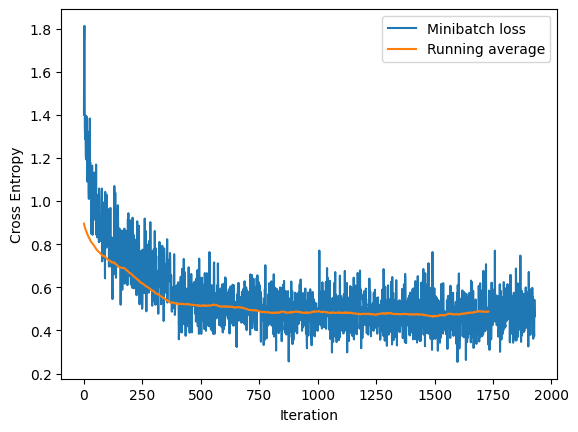

In [19]:
# Starting the plot at 20 to avoid the initial high loss values and for better visualization
loss_list = results['train_loss_per_batch'][20:]

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

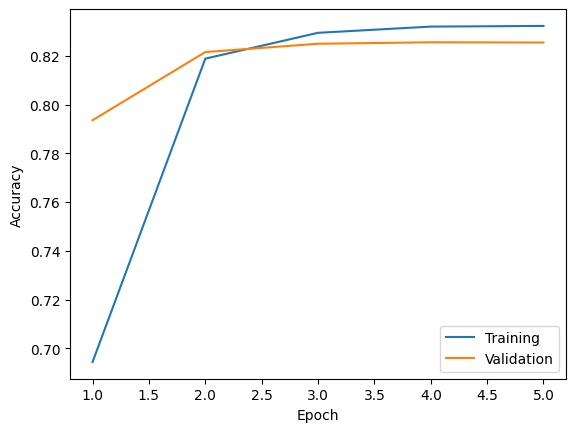

In [20]:
plt.plot(np.arange(1, NUM_EPOCHS+1), results['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), results['val_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

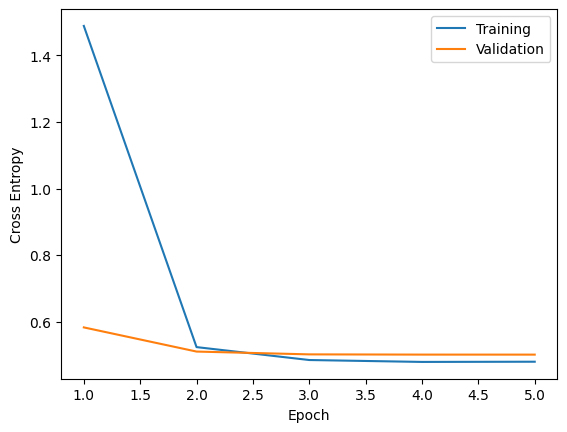

In [21]:
plt.plot(np.arange(1, NUM_EPOCHS+1), results['train_loss_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), results['val_loss_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

100%|██████████| 78/78 [00:03<00:00, 20.11it/s]
/var/folders/vq/zk2fmtnd52x9shn3q484yglm0000gn/T/ipykernel_71135/225879146.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


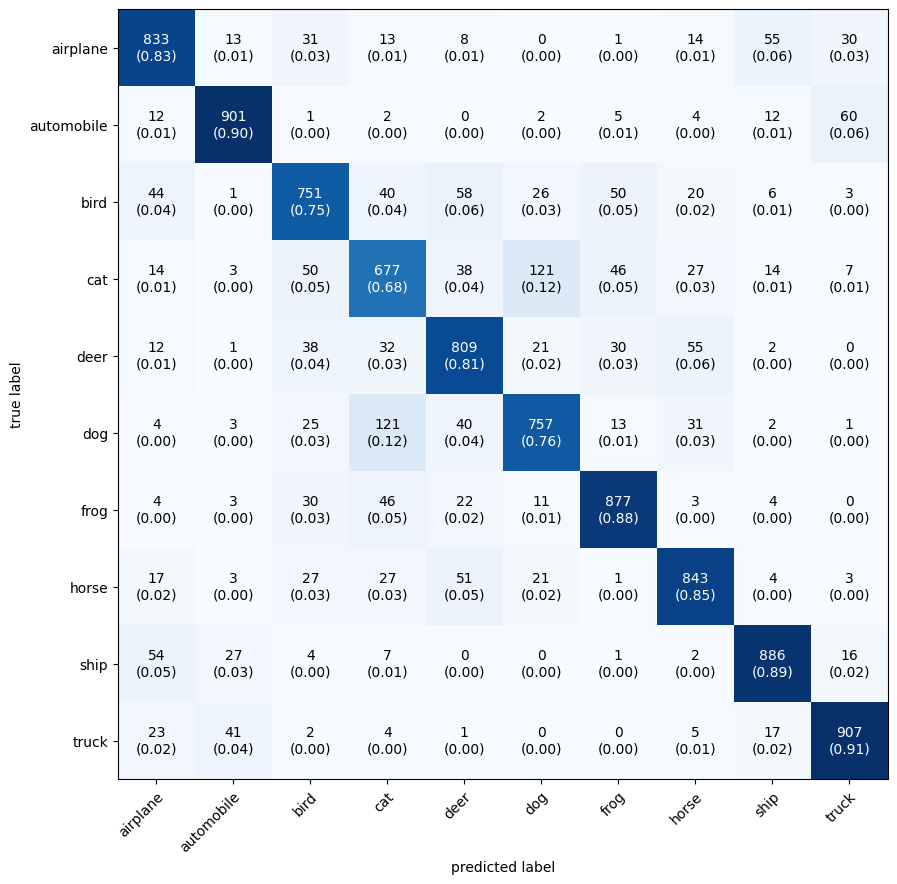

In [22]:
y_preds = []

pytorch_model.eval()
with torch.inference_mode(): 
    for X, y in tqdm(test_dataloader): 
        X, y = X.to(device), y.to(device)
        logits = pytorch_model(X)
        pred = torch.argmax(logits, dim = 1)
        pred = pred.cpu()
        
        y_preds.append(pred)
        
y_preds = torch.cat(y_preds, dim = 0)
test_truth = torch.cat([y for _, y in test_dataloader], dim = 0 )

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)
confmat_tensor = confmat(y_preds.to(device), test_truth.to(device))
confmat_tensor = confmat_tensor.cpu()

fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), figsize=(10, 10), class_names=class_names, show_normed=True)
fig.show()

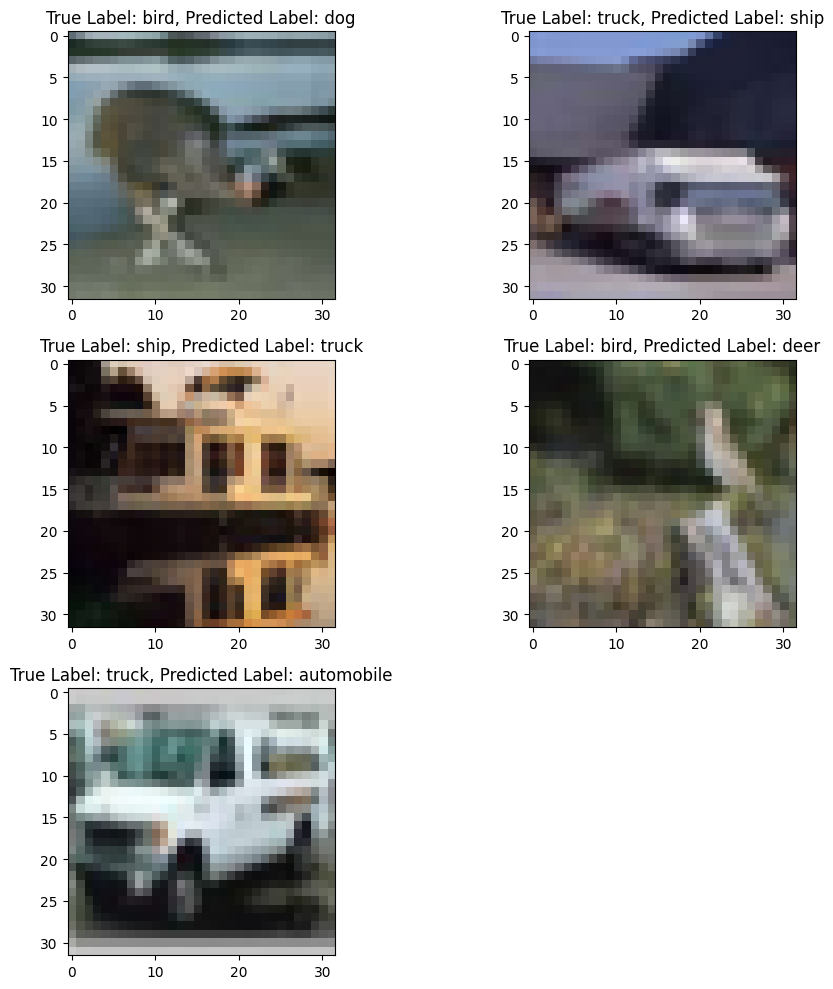

In [23]:
comparison_int = (y_preds == test_truth)
wrong_pred_idx = np.where(comparison_int == False)[0]
random_idx = np.random.choice(wrong_pred_idx, 5)
wrong_pred_idx_sample = wrong_pred_idx[:5]

plt.figure(figsize=(10, 10))

for idx, i in enumerate(random_idx):
    img, label = test_dataset_2[i]
    pred = y_preds[i]

    img = transforms.ToTensor()(img)  # Convert image to PyTorch tensor
    img = img.permute(1, 2, 0)  # Permute dimensions

    plt.subplot(len(wrong_pred_idx_sample) // 2 + len(wrong_pred_idx_sample) % 2, 2, idx + 1)
    plt.title(f"True Label: {class_names[label]}, Predicted Label: {class_names[pred]}")
    plt.imshow(img)

plt.tight_layout()
plt.show()